In [18]:
import numpy as np
import pandas as pd
import json
import tensorflow as tf

from utils import util

## Importación y transformación de datos
Cargamos 501 imágenes aleatorias del dataset Mapillary

In [20]:
dir_img = "./mapillary_img/validation/images"
dir_lab = "./mapillary_img/validation/labels"

img_dataset = tf.keras.utils.image_dataset_from_directory(dir_img, batch_size=5, labels = None, 
                                        image_size = (526, 957), shuffle = False, seed = 0,
                                        validation_split = 0, interpolation = 'bilinear').map(lambda x : x/255)

lab_dataset = tf.data.Dataset.from_tensor_slices(util.get_labels(dir_lab, 501)).batch(5)

Found 501 files belonging to 1 classes.


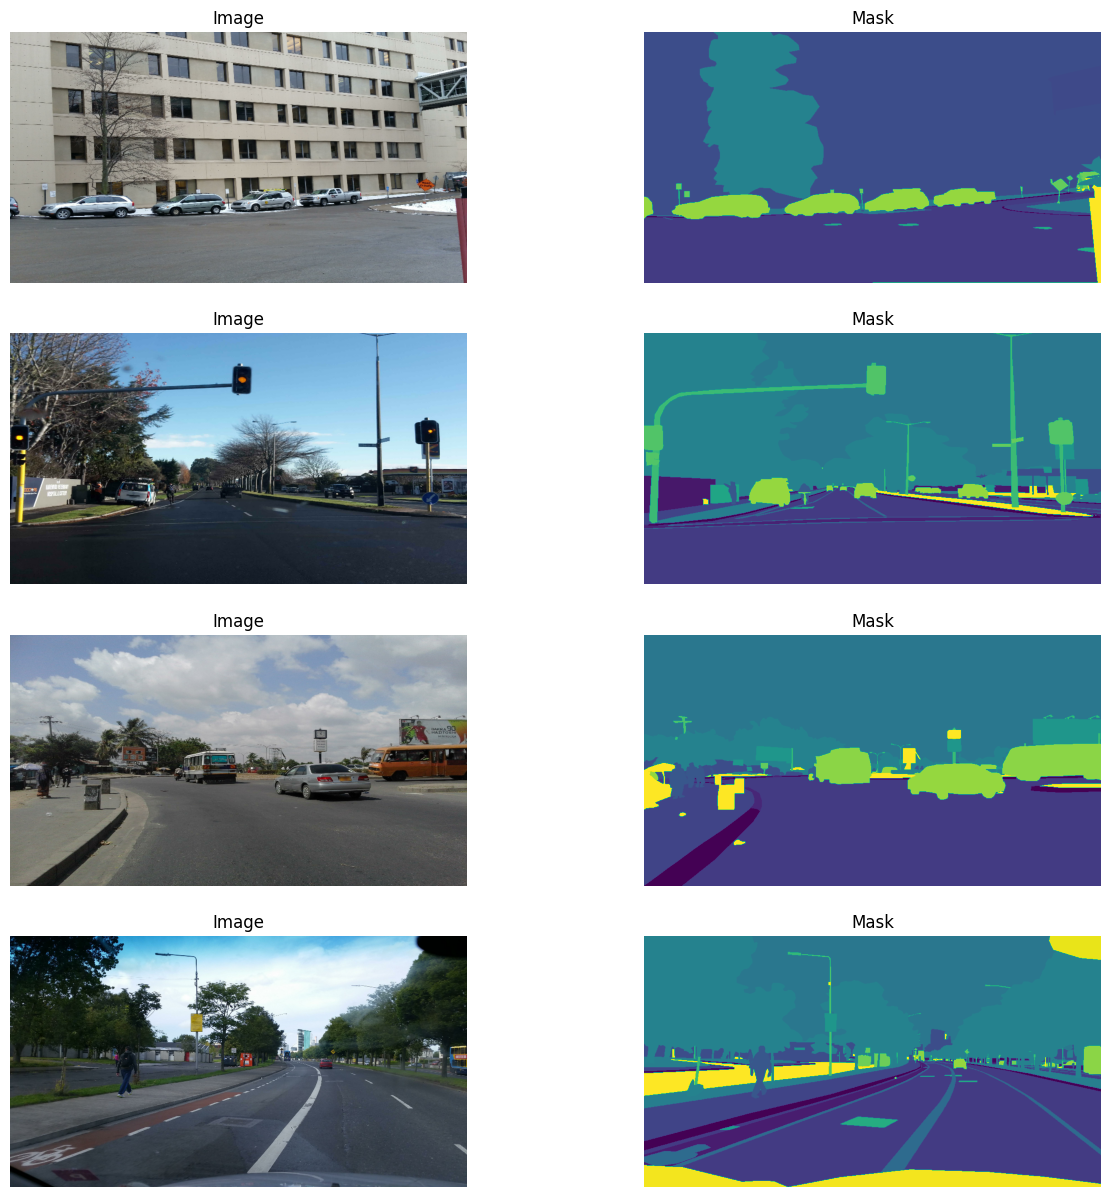

In [22]:
dataset_orig = tf.data.Dataset.zip((img_dataset, lab_dataset))

util.show_image_and_mask(dataset = dataset_orig, color_map = False)

El dataset Mapillary contiene 66 categorías diferentes, por lo que debemos reducirlas para poder hacer inferencia a través de nuestros modelos que predicen las 20 categorías presentes en el dataset cityscapes. Usamos el mapeo de etiquetas que usan en el paper.

URL: https://www.researchgate.net/publication/338116160_Segmentations-Leak_Membership_Inference_Attacks_and_Defenses_in_Semantic_Image_Segmentation

A continuación aplicamos el mapeo de categorías y normalizamos las imágenes para poder pasarlas por los modelos.

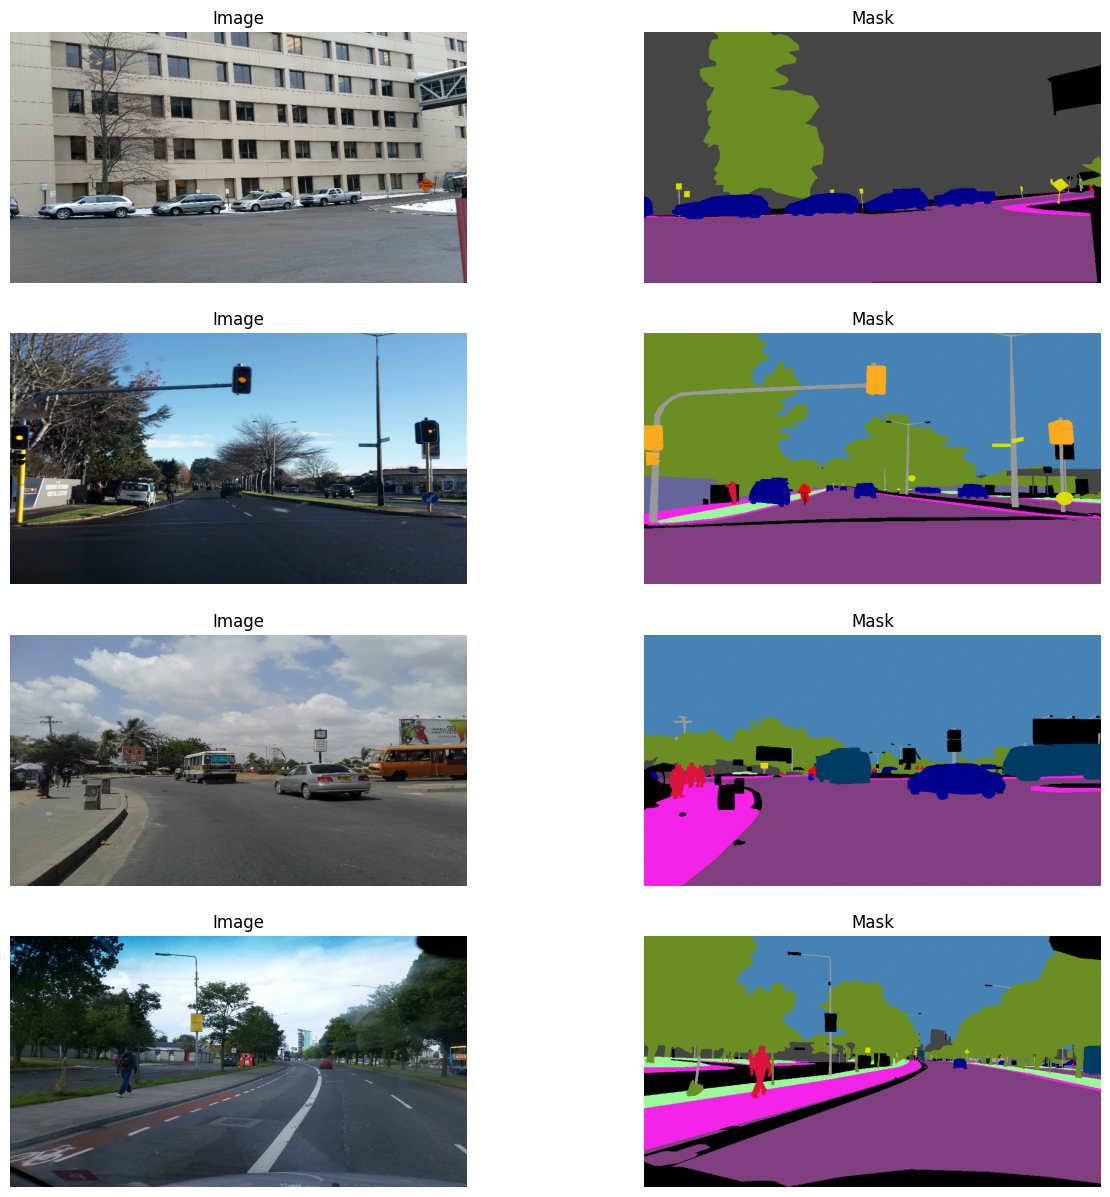

In [24]:
mapeo = json.load(open('mapeo_mapillary.json'))
color_dic = json.load(open('color_dictionary.json'))


img_ds = img_dataset.map(util.normalize)
lab_ds = lab_dataset.map(lambda x: util.map_categories(x, mapeo))

ds = tf.data.Dataset.zip((img_dataset, lab_ds))

util.show_image_and_mask(dataset = ds, color_map = True, dic_colors = color_dic)

Cada color en la máscara de segmentación se corresponde con una categoría del dataset Cityscapes.

In [25]:
cat_cityscapes = json.load(open('cityscapes_categories.json'))
pd.DataFrame(cat_cityscapes.items(), columns = ['id', 'category']).set_index(['id'])

category
id               
0            road
1        sidewalk
2        building
3            wall
4           fence
5            pole
6   traffic light
7    traffic sign
8      vegetation
9         terrain
10            sky
11         person
12          rider
13            car
14          truck
15            bus
16          train
17     motorcycle
18        bicycle
19           void

## Importación de modelos y resultados
A continuación exponemos los resultados de cada uno de los modelos del TFM, así como una comparación de los mismos.

Para cada modelo exponemos la evolucíón de la función de coste durante el proceso de entrenamiento (excepto del modelo entrenado al completo en imágenes reales, ya que este modelo ha sido obtenido a través de *Hugging Face*), las máscaras de segmentación predichas para varias fotografías y el cálculo de las cuatro métricas contempladas en el trabajo (*meanIoU*, *Precision*, *Recall* y *F1-score*)


### Modelo preentrenado en Cityscapes

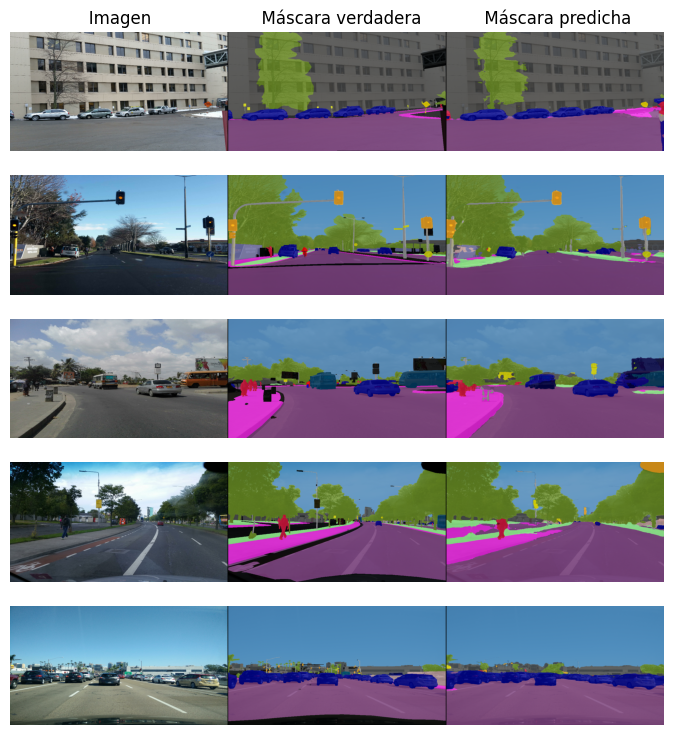

In [6]:
output_cityscapes =np.load('./modelos/cityscapes/results/inferencia_cityscapes.npy')

output_category_cityscapes_ds = util.post_process_output(output_cityscapes)
results_ds_cityscapes = tf.data.Dataset.zip((lab_ds, output_category_cityscapes_ds))

util.show_results(img_dataset, lab_ds, output_category_cityscapes_ds, size = (15, 9), alpha = 0.8, file_name = "img_resultados_cityscapes", dic_color = color_dic, save = False)

In [7]:
results_cityscapes = util.calculate_metrics(results_ds_cityscapes, id_label = cat_cityscapes, num_classes = 19, verbose = False)
results_cityscapes

IoU  Precision    Recall        F1
sky            0.938556   0.980836  0.956088  0.968304
vegetation     0.806484   0.874421  0.912130  0.892877
car            0.772130   0.850138  0.893783  0.871414
road           0.741488   0.763235  0.962996  0.851557
building       0.701693   0.746515  0.921178  0.824700
train          0.462004   0.489852  0.890431  0.632015
bus            0.451760   0.787131  0.514634  0.622362
person         0.424577   0.510187  0.716732  0.596074
terrain        0.422277   0.470705  0.804089  0.593804
traffic sign   0.362855   0.548726  0.517193  0.532493
sidewalk       0.350919   0.598707  0.458844  0.519527
rider          0.349918   0.522872  0.514060  0.518429
pole           0.319342   0.588482  0.411158  0.484092
motorcycle     0.316190   0.527078  0.441423  0.480463
truck          0.304619   0.610235  0.378203  0.466985
traffic light  0.304244   0.674424  0.356621  0.466544
bicycle        0.288365   0.335078  0.674106  0.447645
fence          0.280493   0.414442  0.464624  0.438101
wall           0.201518   0.265261  0.456107  0.335439
Mean           0.745189   0.817073  0.894407  0.853993

### Modelo preentrenado en Cityscapes + Finetuning decoder GTA V

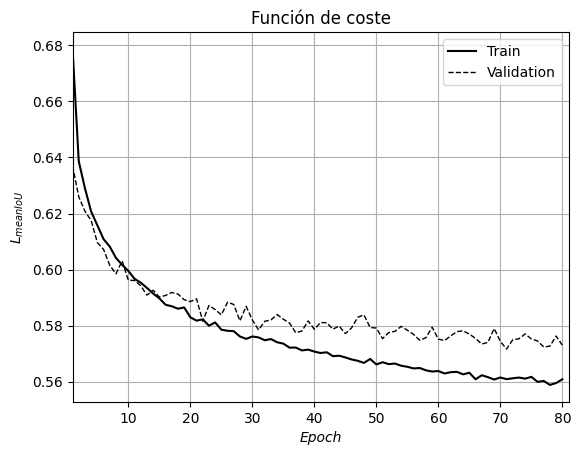

In [16]:
loss_cityscapes_decoder_gta = np.load("./modelos/cityscapes_decoder_gta/history/loss.npy")
val_loss_cityscapes_decoder_gta = np.load("./modelos/cityscapes_decoder_gta/history/val_loss.npy")

util.show_loss_history(loss_cityscapes_decoder_gta, val_loss_cityscapes_decoder_gta, file_name = 'loss_cityscapes_decoder_gta', save = False)

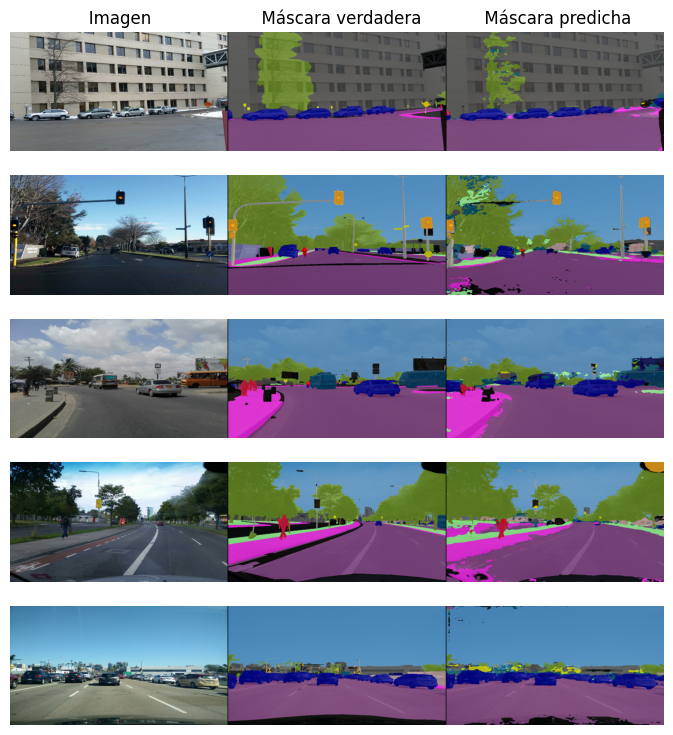

In [7]:
output_cityscapes_decoder_gta =np.load('./modelos/cityscapes_decoder_gta/results/inferencia_cityscapes_decoder_gta.npy')

output_category_cityscapes_decoder_gta_ds = util.post_process_output(output_cityscapes_decoder_gta)
results_ds_cityscapes_decoder_gta = tf.data.Dataset.zip((lab_ds, output_category_cityscapes_decoder_gta_ds))

util.show_results(img_dataset, lab_ds, output_category_cityscapes_decoder_gta_ds, size = (15, 9), alpha = 0.8, file_name = "img_resultados_cityscapes_decoder_gta", dic_color = color_dic, save = False)

In [8]:
results_cityscapes_decoder_gta = util.calculate_metrics(results_ds_cityscapes_decoder_gta, id_label = cat_cityscapes, num_classes = 19, verbose = False)
results_cityscapes_decoder_gta

IoU  Precision    Recall        F1
sky            0.928733   0.963519  0.962581  0.963050
car            0.766174   0.861518  0.873786  0.867609
vegetation     0.759420   0.888226  0.839662  0.863262
building       0.720934   0.834155  0.841559  0.837840
road           0.714128   0.822958  0.843754  0.833226
person         0.454825   0.599359  0.653509  0.625264
bus            0.397640   0.770045  0.451221  0.569017
terrain        0.329410   0.345292  0.877478  0.495573
pole           0.308122   0.615954  0.381392  0.471090
sidewalk       0.307430   0.385286  0.603391  0.470281
traffic light  0.276480   0.706615  0.312333  0.433191
fence          0.265448   0.417081  0.422012  0.419532
truck          0.256008   0.401791  0.413690  0.407654
rider          0.247449   0.440717  0.360723  0.396728
motorcycle     0.229188   0.561676  0.279108  0.372909
wall           0.194794   0.268016  0.416232  0.326071
bicycle        0.159628   0.489304  0.191540  0.275310
traffic sign   0.145821   0.656897  0.157842  0.254526
train          0.024010   0.024150  0.805118  0.046894
Mean           0.701042   0.800987  0.848905  0.824250

### Modelo preentrenado en Cityscapes + Finetuning completo GTA V

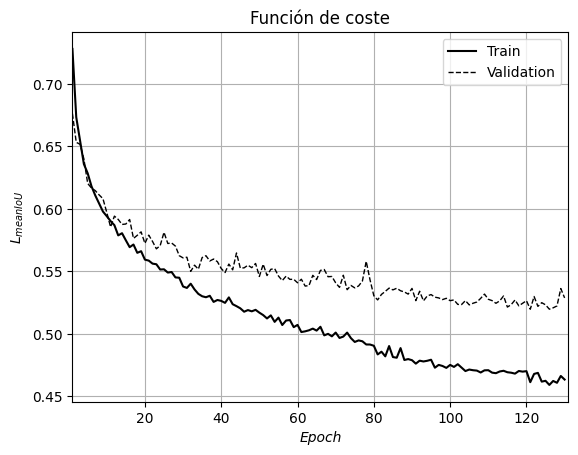

In [17]:
loss_cityscapes_completo_gta = np.load("./modelos/cityscapes_completo_gta/history/loss.npy")
val_loss_cityscapes_decoder_gta = np.load("./modelos/cityscapes_completo_gta/history/val_loss.npy")

util.show_loss_history(loss_cityscapes_completo_gta, val_loss_cityscapes_decoder_gta, file_name = 'loss_cityscapes_completo_gta', save = False)

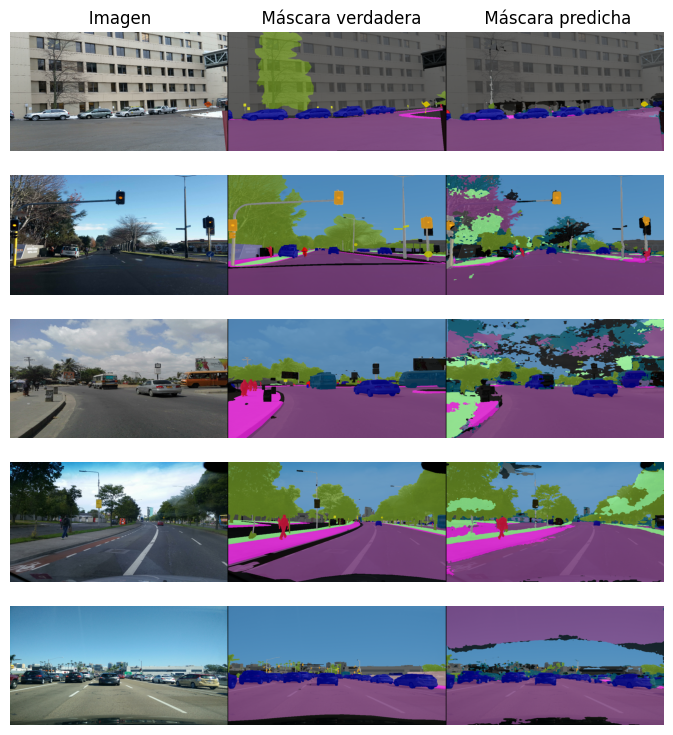

In [8]:
output_cityscapes_completo_gta =np.load('./modelos/cityscapes_completo_gta/results/inferencia_cityscapes_completo_gta.npy')

output_category_cityscapes_completo_gta_ds = util.post_process_output(output_cityscapes_completo_gta)
results_ds_cityscapes_completo_gta = tf.data.Dataset.zip((lab_ds, output_category_cityscapes_completo_gta_ds))

util.show_results(img_dataset, lab_ds, output_category_cityscapes_completo_gta_ds, size = (15, 9), alpha = 0.8, file_name = "img_resultados_cityscapes_completo_gta", dic_color = color_dic, save = False)

In [10]:
results_cityscapes_completo_gta = util.calculate_metrics(results_ds_cityscapes_completo_gta, id_label = cat_cityscapes, num_classes = 19, verbose = False)
results_cityscapes_completo_gta

IoU  Precision    Recall        F1
sky            0.751281   0.940861  0.788517  0.857979
building       0.638617   0.773442  0.785569  0.779459
road           0.630854   0.666497  0.921852  0.773648
vegetation     0.627748   0.873227  0.690695  0.771309
car            0.613021   0.891698  0.662335  0.760090
person         0.403770   0.624749  0.533045  0.575265
terrain        0.272547   0.289514  0.823035  0.428349
sidewalk       0.247871   0.458818  0.350282  0.397270
pole           0.231104   0.674540  0.260108  0.375442
traffic light  0.143691   0.785331  0.149566  0.251276
wall           0.141179   0.192539  0.346083  0.247426
fence          0.116095   0.236495  0.185694  0.208038
rider          0.100828   0.431934  0.116242  0.183185
truck          0.086538   0.221763  0.124280  0.159291
traffic sign   0.080257   0.880803  0.081139  0.148590
motorcycle     0.065479   0.643071  0.067949  0.122911
bicycle        0.054914   0.384077  0.060216  0.104110
bus            0.007498   0.359997  0.007599  0.014884
train          0.002527   0.002568  0.134940  0.005040
Mean           0.585271   0.727676  0.749416  0.738386

### Modelo preentrenado en GTA V

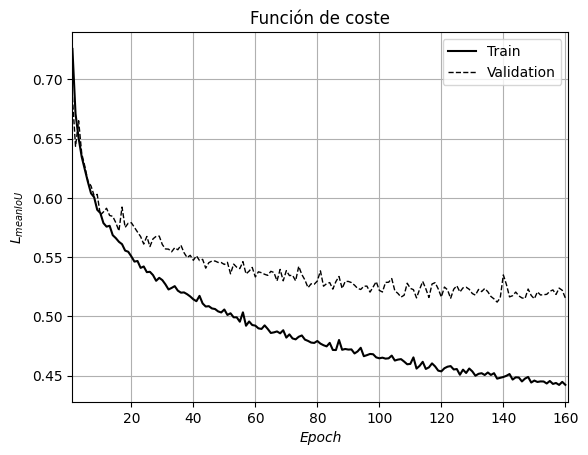

In [18]:
loss_gta = np.load("./modelos/gta/history/loss.npy")
val_loss_gta = np.load("./modelos/gta/history/val_loss.npy")

util.show_loss_history(loss_gta, val_loss_gta, file_name = 'loss_gta', save = False)

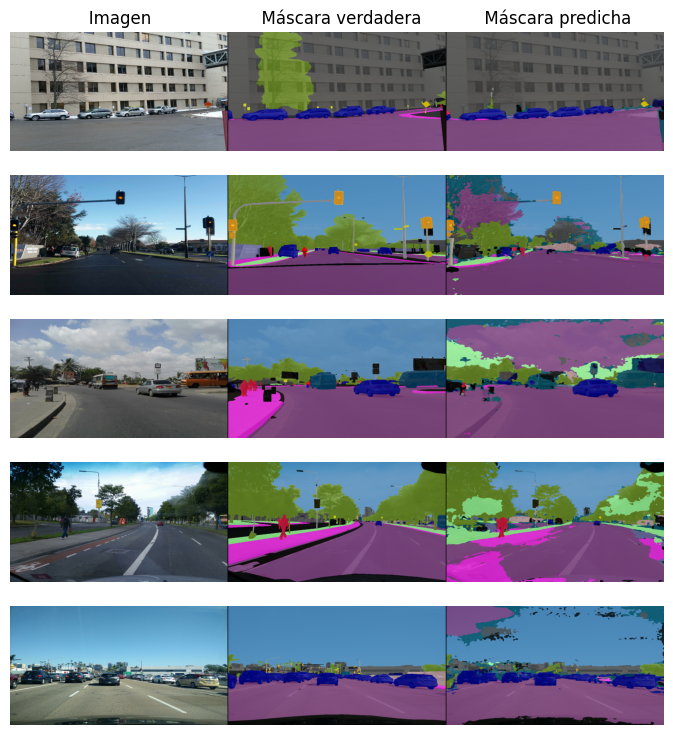

In [9]:
output_gta =np.load('./modelos/gta/results/inferencia_gta.npy')

output_category_gta_ds = util.post_process_output(output_gta)
results_ds_gta = tf.data.Dataset.zip((lab_ds, output_category_gta_ds))

util.show_results(img_dataset, lab_ds, output_category_gta_ds, size = (15, 9), alpha = 0.8, file_name = "img_resultados_cityscapes_completo_gta", dic_color = color_dic, save = False)

In [12]:
results_gta = util.calculate_metrics(results_ds_gta, id_label = cat_cityscapes, num_classes = 19, verbose = False)
results_gta

IoU  Precision    Recall        F1
sky            0.741634   0.944097  0.775698  0.851653
vegetation     0.619753   0.858928  0.689986  0.765244
car            0.581145   0.863654  0.639849  0.735094
building       0.580489   0.690484  0.784668  0.734569
road           0.558572   0.671701  0.768331  0.716774
person         0.356097   0.600492  0.466652  0.525179
terrain        0.226437   0.241312  0.786024  0.369260
traffic light  0.212496   0.755934  0.228149  0.350510
pole           0.196856   0.689613  0.215994  0.328955
sidewalk       0.174466   0.233969  0.406885  0.297099
fence          0.169093   0.339288  0.252108  0.289272
truck          0.164443   0.268524  0.297879  0.282441
traffic sign   0.111260   0.861706  0.113283  0.200242
wall           0.066809   0.133255  0.118153  0.125250
rider          0.023650   0.518761  0.024181  0.046208
motorcycle     0.022589   0.351982  0.023569  0.044180
bicycle        0.013772   0.357562  0.014122  0.027170
train          0.002534   0.002554  0.241460  0.005055
bus            0.001002   0.036875  0.001029  0.002002
Mean           0.527275   0.672086  0.709905  0.690478

### Modelo preentrenado en GTA V + Finetuning decoder Cityscapes

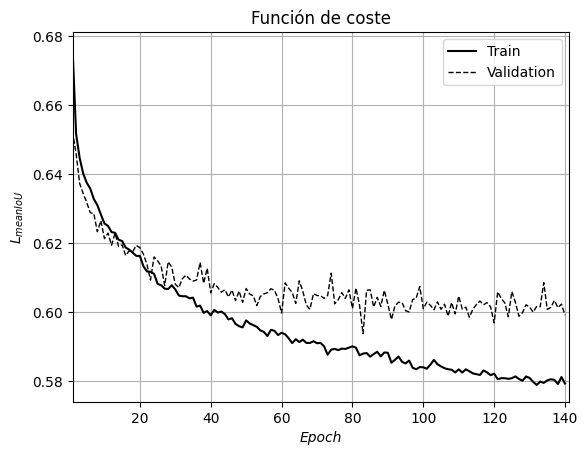

In [19]:
loss_gta_decoder_cityscapes = np.load("./modelos/gta_decoder_cityscapes/history/loss.npy")
val_loss_gta_decoder_cityscapes = np.load("./modelos/gta_decoder_cityscapes/history/val_loss.npy")

util.show_loss_history(loss_gta_decoder_cityscapes, val_loss_gta_decoder_cityscapes, file_name = 'loss_gta_decoder_cityscapes', save = False)

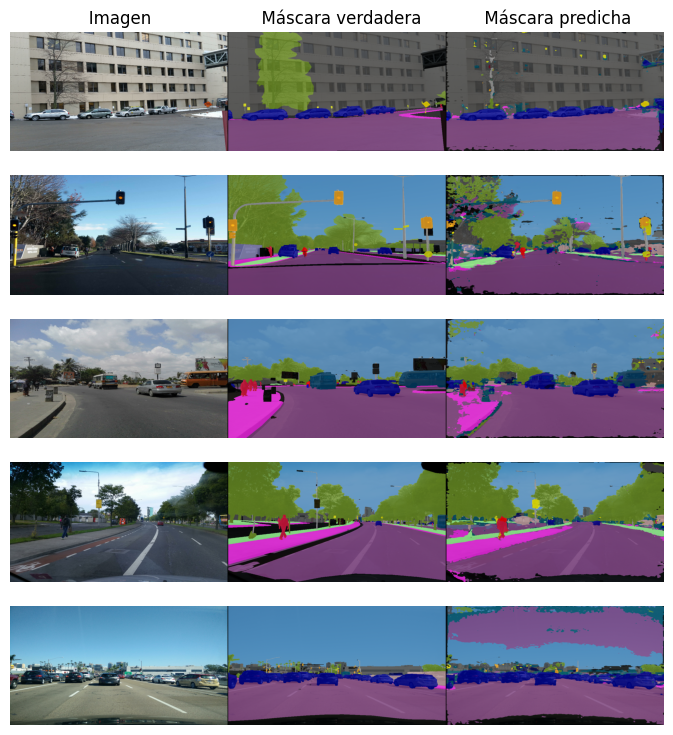

In [10]:
output_gta_decoder_cityscapes =np.load('./modelos/gta_decoder_cityscapes/results/inferencia_gta_decoder_cityscapes.npy')

output_category_gta_decoder_cityscapes_ds = util.post_process_output(output_gta_decoder_cityscapes)
results_ds_gta_decoder_cityscapes = tf.data.Dataset.zip((lab_ds, output_category_gta_decoder_cityscapes_ds))

util.show_results(img_dataset, lab_ds, output_category_gta_decoder_cityscapes_ds, size = (15, 9), alpha = 0.8, file_name = "img_resultados_gta_decoder_gta", dic_color = color_dic, save = False)

In [14]:
results_gta_decoder_cityscapes = util.calculate_metrics(results_ds_gta_decoder_cityscapes, id_label = cat_cityscapes, num_classes = 19, verbose = False)
results_gta_decoder_cityscapes

IoU  Precision    Recall        F1
sky            0.851846   0.975664  0.870338  0.919997
vegetation     0.692144   0.843728  0.793921  0.818068
road           0.650774   0.709166  0.887686  0.788447
car            0.625252   0.704626  0.847341  0.769422
building       0.614992   0.780048  0.744011  0.761603
terrain        0.419580   0.617734  0.566729  0.591133
person         0.348896   0.548366  0.489576  0.517306
pole           0.282031   0.528770  0.376714  0.439975
traffic light  0.264463   0.542916  0.340213  0.418301
traffic sign   0.196703   0.367190  0.297582  0.328741
fence          0.192555   0.273868  0.393404  0.322929
sidewalk       0.185051   0.360606  0.275421  0.312309
rider          0.140871   0.267923  0.229029  0.246954
truck          0.114909   0.226539  0.189096  0.206131
motorcycle     0.111517   0.251942  0.166720  0.200658
bicycle        0.095285   0.116964  0.339540  0.173992
wall           0.094923   0.200824  0.152545  0.173387
bus            0.054653   0.108295  0.099373  0.103642
train          0.002851   0.002888  0.180585  0.005686
Mean           0.622886   0.751056  0.784946  0.767627

### Modelo preentrenado en GTA V + Finetuning completo Cityscapes

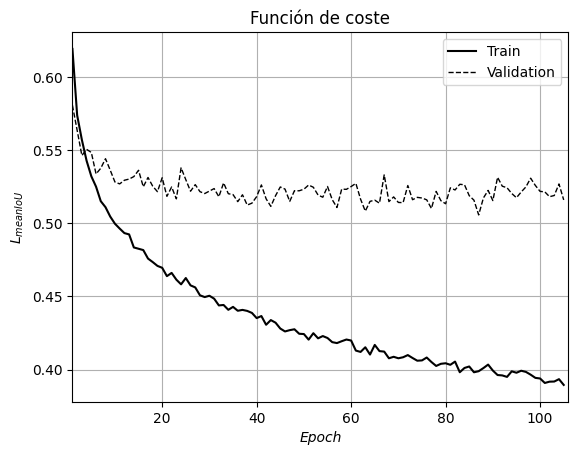

In [20]:
loss_gta_completo_cityscapes = np.load("./modelos/gta_completo_cityscapes/history/loss.npy")
val_loss_gta_completo_cityscapes = np.load("./modelos/gta_completo_cityscapes/history/val_loss.npy")

util.show_loss_history(loss_gta_completo_cityscapes, val_loss_gta_completo_cityscapes, file_name = 'loss_gta_completo_cityscapes', save = False)

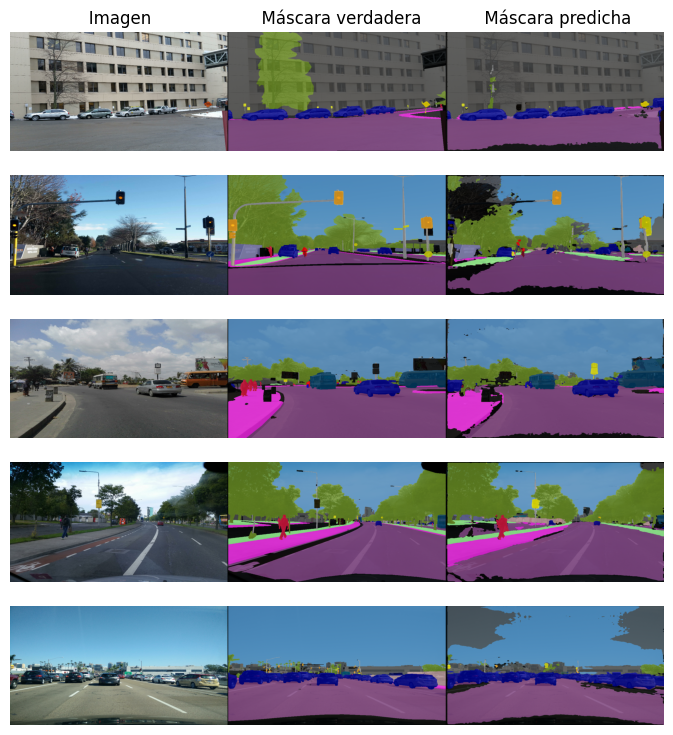

In [11]:
output_gta_completo_cityscapes =np.load('./modelos/gta_completo_cityscapes/results/inferencia_gta_completo_cityscapes.npy')

output_category_gta_completo_cityscapes_ds = util.post_process_output(output_gta_completo_cityscapes)
results_ds_gta_completo_cityscapes = tf.data.Dataset.zip((lab_ds, output_category_gta_completo_cityscapes_ds))

util.show_results(img_dataset, lab_ds, output_category_gta_completo_cityscapes_ds, size = (15, 9), alpha = 0.8, file_name = "img_resultados_gta_completo_gta", dic_color = color_dic, save = False)

In [16]:
results_gta_completo_cityscapes = util.calculate_metrics(results_ds_gta_completo_cityscapes, id_label = cat_cityscapes, num_classes = 19, verbose = False)
results_gta_completo_cityscapes

IoU  Precision    Recall        F1
sky            0.817540   0.981795  0.830125  0.899612
vegetation     0.741670   0.834132  0.869975  0.851677
car            0.682627   0.811419  0.811346  0.811382
road           0.665636   0.825757  0.774406  0.799258
building       0.541025   0.630489  0.792222  0.702163
terrain        0.399042   0.610849  0.535064  0.570451
person         0.375353   0.563447  0.529278  0.545828
traffic sign   0.291739   0.509727  0.405533  0.451699
traffic light  0.261640   0.709107  0.293098  0.414761
pole           0.260654   0.614103  0.311710  0.413522
fence          0.246115   0.471076  0.340096  0.395011
sidewalk       0.240430   0.490632  0.320408  0.387657
truck          0.186022   0.375185  0.269516  0.313690
bus            0.175407   0.476652  0.217247  0.298462
motorcycle     0.161352   0.368239  0.223114  0.277869
wall           0.158965   0.360074  0.221558  0.274322
rider          0.156106   0.317204  0.235108  0.270055
bicycle        0.143362   0.182608  0.400140  0.250773
train          0.012221   0.014503  0.072070  0.024147
Mean           0.648626   0.809936  0.765079  0.786869

### Comparación de modelos

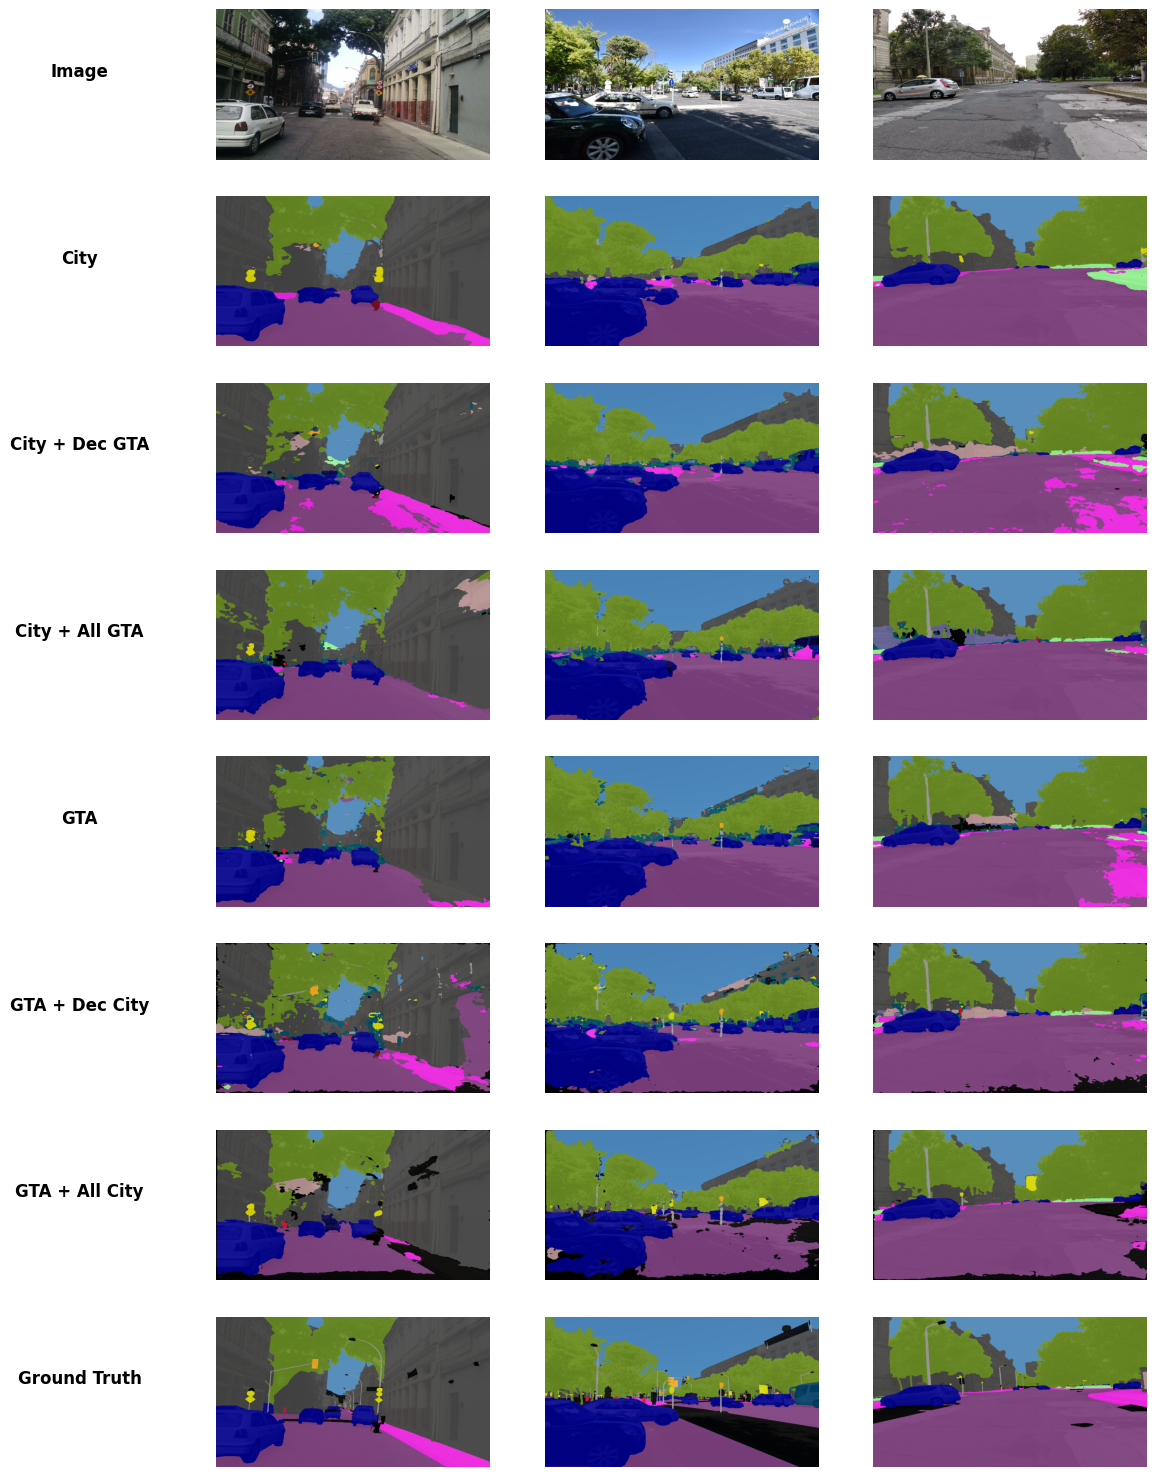

In [12]:
util.show_results_comparison(
    img_ds = img_dataset, 
    mask_truth_ds = lab_ds, 
    predicted_mask_ds_1 = output_category_cityscapes_ds, 
    predicted_mask_ds_2 = output_category_cityscapes_decoder_gta_ds, 
    predicted_mask_ds_3 = output_category_cityscapes_completo_gta_ds, 
    predicted_mask_ds_4 = output_category_gta_ds, 
    predicted_mask_ds_5 = output_category_gta_decoder_cityscapes_ds, 
    predicted_mask_ds_6 = output_category_gta_completo_cityscapes_ds, 
    dic_color = color_dic,
    size = (12,19), alpha = 0.9, seed = 0, file_name = "img_comparison", save = False)